### Scientific Research Paper Notebook

**Topic:** Assessment of the creditworthiness of the individual borrower in a commercial bank by means of machine learning

In [118]:
# Kaggle API
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

# DA
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import io, zipfile
from itertools import product

# ML
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import roc_auc_score

# Presets
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 3000)
sns.set(rc={"figure.figsize":(16, 4)})

### Dataset Download

In [4]:
api.dataset_download_file('laotse/credit-risk-dataset',
                          file_name='credit_risk_dataset.csv')

archive = zipfile.ZipFile('credit_risk_dataset.csv.zip', 'r')
data = archive.read('credit_risk_dataset.csv')
bytes_io = io.BytesIO(data)
df = pd.read_csv(bytes_io)

### EDA

In [6]:
df.shape

(32581, 12)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [15]:
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


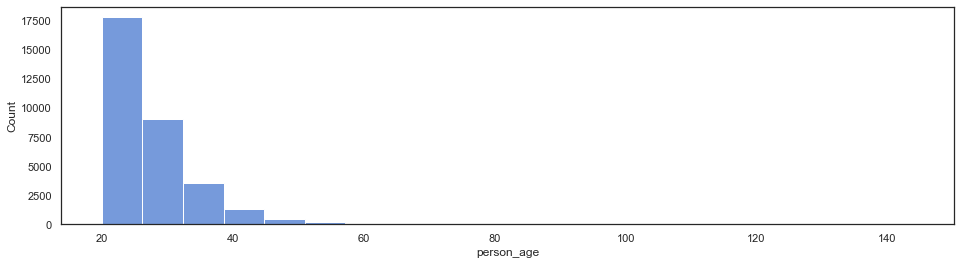

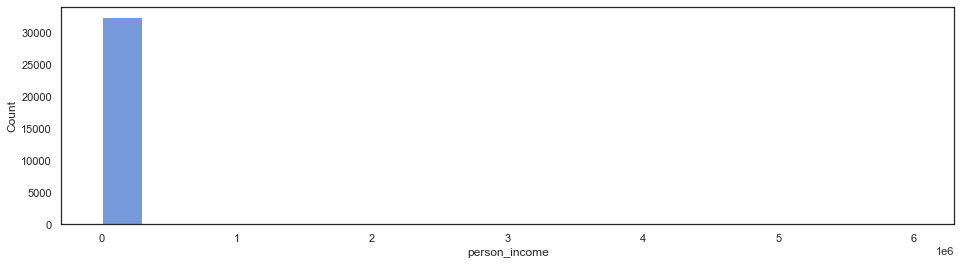

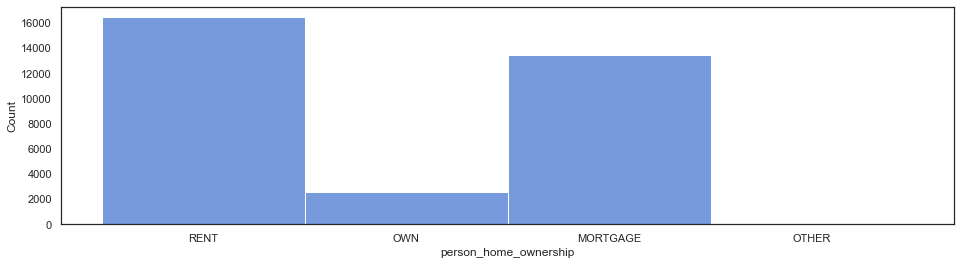

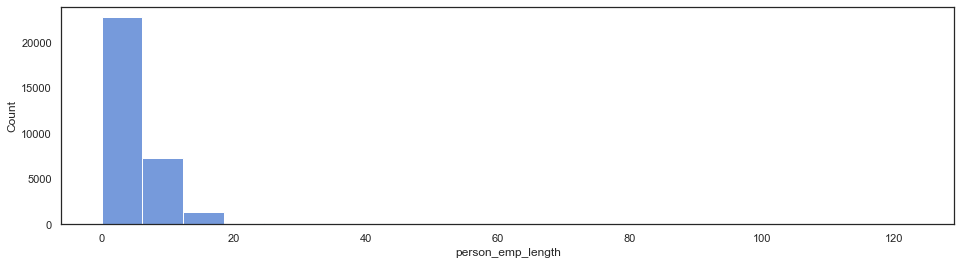

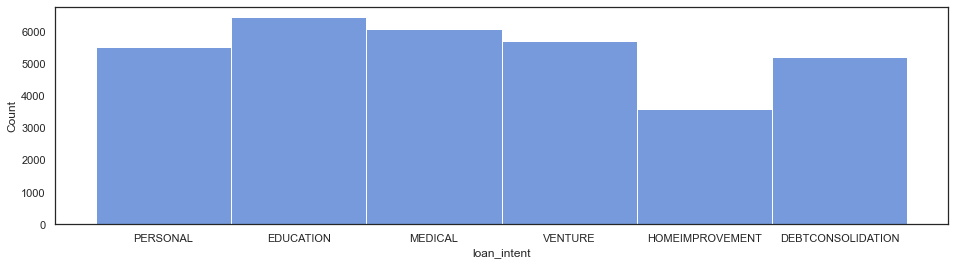

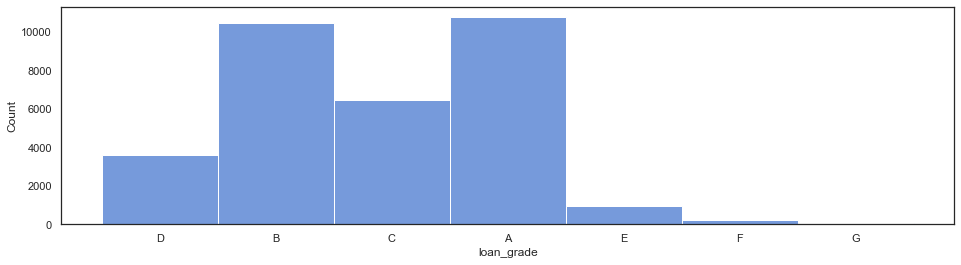

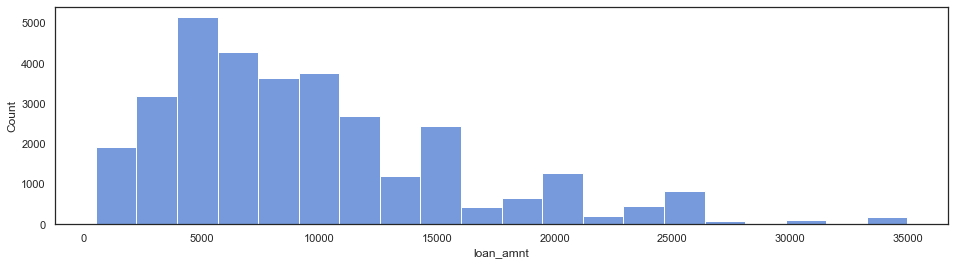

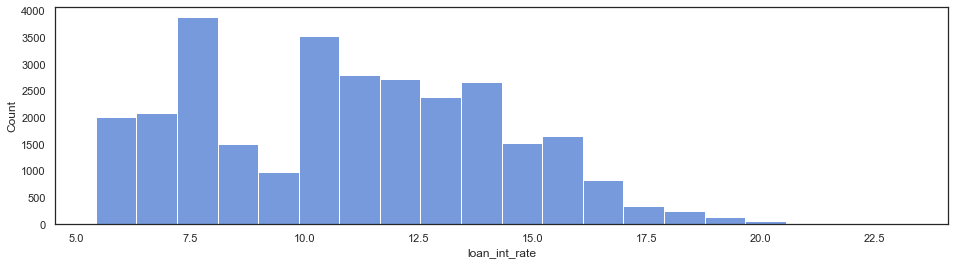

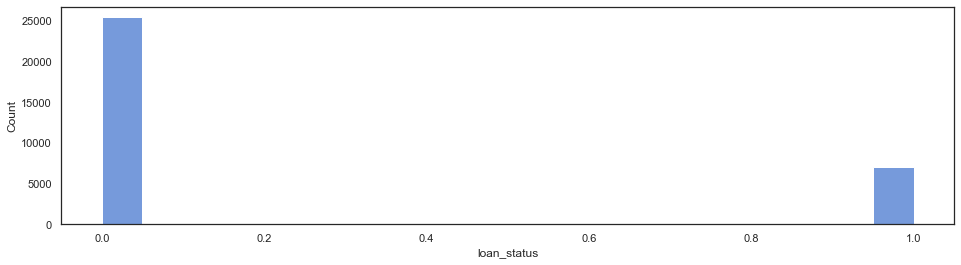

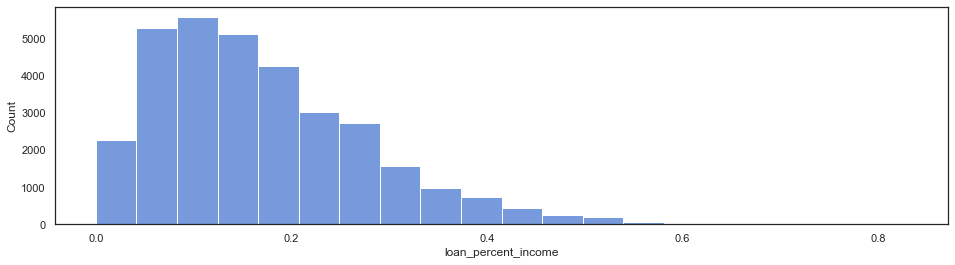

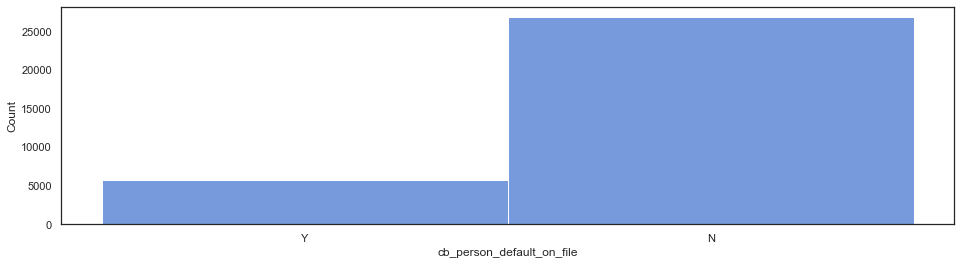

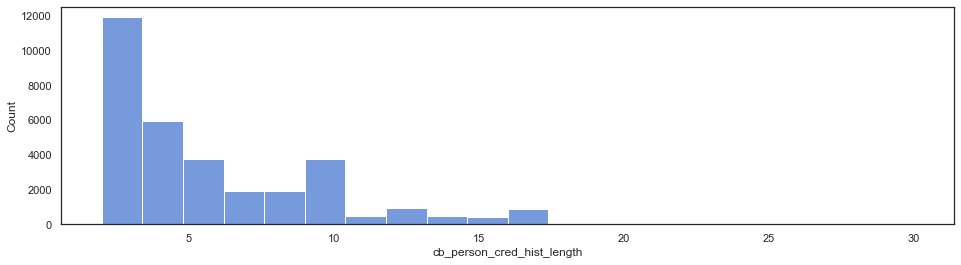

In [14]:
sns.set(style="white", palette="muted")
for col in df.columns:
    sns.histplot(df[col], kde=False, label=col, bins=20)
    plt.show()

### Outlier detection

In [24]:
df.nlargest(10, 'person_age') # 5 unreasonable outliers by age

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
81,144,250000,RENT,4.0,VENTURE,C,4800,13.57,0,0.02,N,3
183,144,200000,MORTGAGE,4.0,EDUCATION,B,6000,11.86,0,0.03,N,2
32297,144,6000000,MORTGAGE,12.0,PERSONAL,C,5000,12.73,0,0.00,N,25
575,123,80004,RENT,2.0,EDUCATION,B,20400,10.25,0,0.25,N,3
747,123,78000,RENT,7.0,VENTURE,B,20000,NaN,0,0.26,N,4
32416,94,24000,RENT,1.0,MEDICAL,C,6500,NaN,0,0.27,N,27
32506,84,94800,MORTGAGE,2.0,PERSONAL,A,10000,7.51,0,0.11,N,24
32422,80,64000,RENT,7.0,MEDICAL,B,6800,11.71,0,0.11,N,25
32355,78,48000,RENT,41.0,MEDICAL,A,3000,7.51,0,0.06,N,25
32534,76,75000,RENT,23.0,MEDICAL,A,15000,8.94,0,0.20,N,25


In [23]:
df.nlargest(6, 'person_emp_length') # 2 unreasonable outliers by employment length

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
210,21,192000,MORTGAGE,123.0,VENTURE,A,20000,6.54,0,0.10,N,4
32355,78,48000,RENT,41.0,MEDICAL,A,3000,7.51,0,0.06,N,25
32515,53,106000,MORTGAGE,38.0,PERSONAL,B,20000,9.88,0,0.19,N,23
32428,58,49000,MORTGAGE,34.0,MEDICAL,D,7500,13.55,1,0.15,Y,24
30914,48,70000,MORTGAGE,31.0,HOMEIMPROVEMENT,D,9000,14.54,0,0.13,N,17


In [27]:
df[df['person_emp_length'] > (df['person_age']+14)] # We confront the same unreasonable outliers

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
210,21,192000,MORTGAGE,123.0,VENTURE,A,20000,6.54,0,0.10,N,4


### Preprocessing

In [39]:
# Clearing unreasonable outliers
df = df[~(df['person_emp_length'] > (df['person_age']+14))].query("person_age < 100")

# Removing datapoints without interest rate
df = df[~df['loan_int_rate'].isna()]

# Filling NaNs in employment length (0 is no employment, NaN means employment unknown)
age_fill_value = np.median(df['person_emp_length'])
df['person_emp_length'] = df['person_emp_length'].fillna(age_fill_value)

# Converting all categorical variables to dummies
df = pd.get_dummies(df, drop_first=False)

# Receive 26 features and 1 label
df.shape

(29459, 27)

In [40]:
# Dealing with imbalanced data, if the model is highly inaccurate -> possible to apply data sampling measures
df['loan_status'].value_counts()

0    22996
1     6463
Name: loan_status, dtype: int64

### Train test split
Spliting the dataset into training and test data for model training and evaluation correspondingly

In [41]:
X = df.drop('loan_status', axis=1)
Y = df['loan_status']


X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size = 0.2,
                                                    stratify = Y,
                                                    random_state = 1)

### Best XGBoost hyperparameter search - K-fold cross-validation

In [74]:
idx = np.random.choice(range(5), size=len(X_train), replace=True)
error = []

for n_estimators, eta in product([500, 600, 700, 800, 900, 1000], [0.01, 0.03, 0.05, 0.1, 0.2]):
    xgb = XGBClassifier(objective='binary:logistic', n_estimators=n_estimators, learning_rate=eta)
    cv_error = []
    for k in range(5):
        fold_idx = idx == k
        train_X = X_train.loc[~fold_idx]; train_y = Y_train[~fold_idx]
        valid_X = X_train.loc[fold_idx]; valid_y = Y_train[fold_idx]
        
        xgb.fit(train_X, train_y)
        pred = xgb.predict_proba(valid_X)[:, 1]
        cv_error.append(np.mean(abs(valid_y - pred) > 0.5))
    error.append({
        'n_estimators': n_estimators,
        'eta': eta,
        'avg_error': np.mean(cv_error)
    })
    print(error[-1])
errors = pd.DataFrame(error)

{'n_estimators': 500, 'eta': 0.01, 'avg_error': 0.06708181115779041}
{'n_estimators': 500, 'eta': 0.03, 'avg_error': 0.06536958120336077}
{'n_estimators': 500, 'eta': 0.05, 'avg_error': 0.06516188881535447}
{'n_estimators': 500, 'eta': 0.1, 'avg_error': 0.0648640141208761}
{'n_estimators': 500, 'eta': 0.2, 'avg_error': 0.06519872744563882}
{'n_estimators': 600, 'eta': 0.01, 'avg_error': 0.06640236510294008}
{'n_estimators': 600, 'eta': 0.03, 'avg_error': 0.06541316976817878}
{'n_estimators': 600, 'eta': 0.05, 'avg_error': 0.06524457809534452}
{'n_estimators': 600, 'eta': 0.1, 'avg_error': 0.06456595402053403}
{'n_estimators': 600, 'eta': 0.2, 'avg_error': 0.06557472589758957}
{'n_estimators': 700, 'eta': 0.01, 'avg_error': 0.06597563787790668}
{'n_estimators': 700, 'eta': 0.03, 'avg_error': 0.06541430449692523}
{'n_estimators': 700, 'eta': 0.05, 'avg_error': 0.06481200059039338}
{'n_estimators': 700, 'eta': 0.1, 'avg_error': 0.06465588122287688}
{'n_estimators': 700, 'eta': 0.2, 'avg_e

### Applying the best hyperparameters to XGBoost
According to cross-validation, average error of the model is minimized at ~800 estimators and 0.05 learning rate (eta) + slight manual tuning

In [149]:
xgb_model_ = XGBClassifier(objective='binary:logistic',
                           eval_metric='logloss',
                           n_estimators=820,
                           max_depth=4,
                           learning_rate=0.05,
                           tree_method='hist',
                           subsample=0.77)
xgb_model_.fit(X_train, Y_train)
X_train_prediction = xgb_model_.predict(X_train)
roc_auc_score(X_train_prediction, Y_train)

0.9611868039975682

In [150]:
X_test_prediction = xgb_model_.predict(X_test)
roc_auc_score(X_test_prediction, Y_test)

0.9513313205736054

In [126]:
# Change of presets
sns.set(rc={"figure.figsize":(14, 8)})

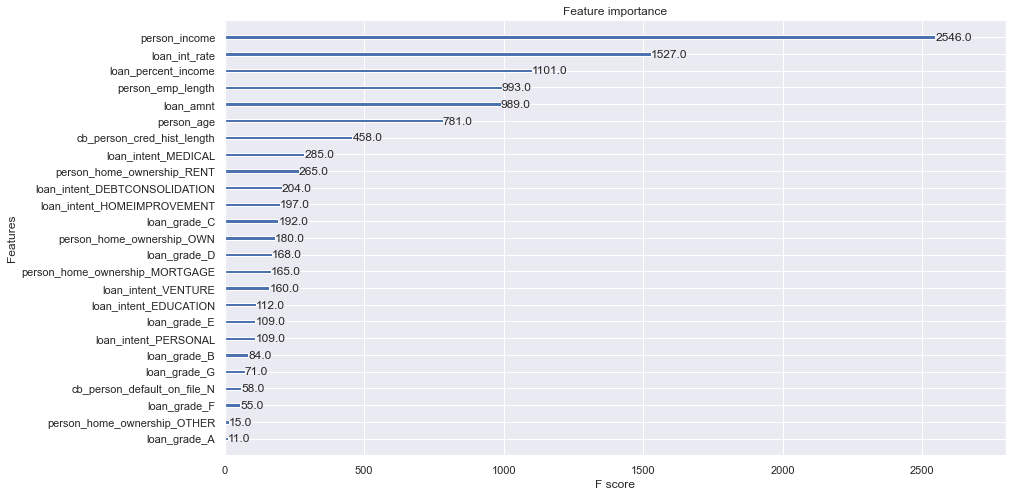

In [127]:
plot_importance(xgb_model_)
plt.show()

#### Scatterplot of test data initial values VS predicted values with two most important features as axes

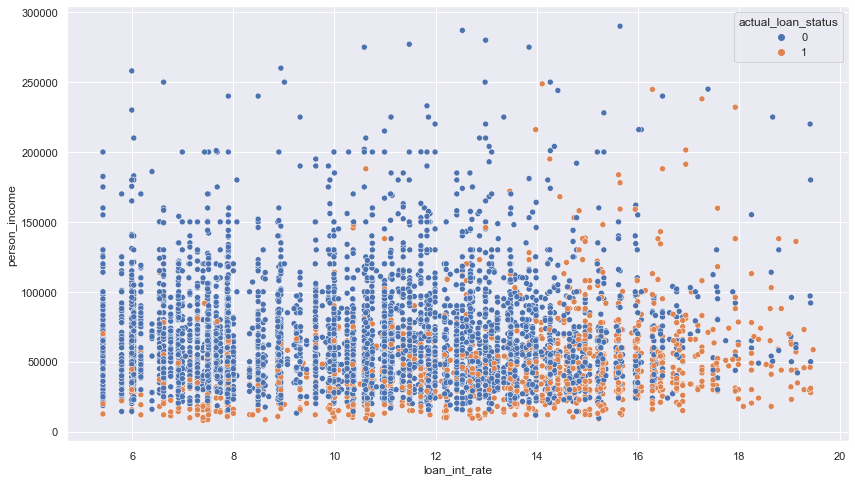

In [169]:
temp = pd.DataFrame({'actual_loan_status': Y_test, 
                     'predicted_loan_status': X_test_prediction})
scatter_df = pd.concat([X_test, temp], axis=1)
scatter_df = scatter_df[(scatter_df['person_income']<300000) & (scatter_df['loan_int_rate']<19.5)]

sns.scatterplot(data=scatter_df, x='loan_int_rate', y='person_income', hue='actual_loan_status')
plt.show()

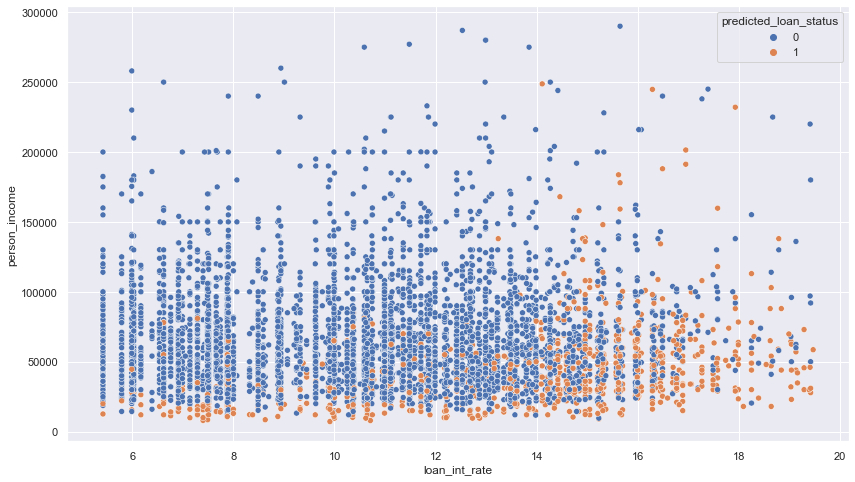

In [170]:
sns.scatterplot(data=scatter_df, x='loan_int_rate', y='person_income', hue='predicted_loan_status')
plt.show()